# 最適腕識別_実装
- 「バンディット問題の理論とアルゴリズム」の6章(最適腕識別とA/Bテスト)のアルゴリズムを実装。
- git管理へ移行する前の、全コードベタ書きのnotebookを、試行錯誤の証跡として残しておく。
- 以下のリポジトリを参考にした。
- https://github.com/johnmyleswhite/BanditsBook

## 前準備

In [1]:
import warnings
warnings.simplefilter('ignore')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 参考リポジトリの処理を流用(arms/normal.py。正規乱数を返す処理→アームとして使用)
class NormalArm():
  def __init__(self, name, mu, sigma):
    self.name = name #最終結果を返す時のために、armの名前を設定できるようにしておく。
    self.mu = mu
    self.sigma = sigma
  
  def draw(self):
    return random.gauss(self.mu, self.sigma)

In [3]:
# armのオブジェクト生成。
arm1 = NormalArm('arm1', 3.0, 1.0)  # X1 ~ N(μ1, σ1)
arm2 = NormalArm('arm2', 10.0, 1.0)  # X2 ~ N(μ2, σ2)
arm3 = NormalArm('arm3', 10.1, 1.0)  # X3 ~ N(μ3, σ3)
arm4 = NormalArm('arm4', 10.15, 1.0)  # X3 ~ N(μ4, σ4)

In [4]:
# arm動作テスト_1: 各アームから報酬を1件ずつ吐き出す
reword_ = [arm1.draw(), arm2.draw(), arm3.draw()]
print(reword_)

[4.216244008736657, 8.959714062910473, 11.489174475073948]


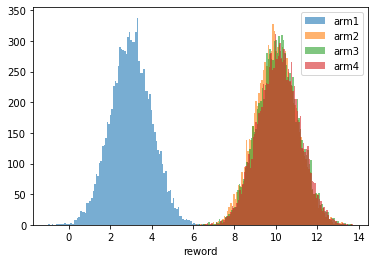

In [5]:
# arm動作テスト_2: 各アームをx回ずつ引いて報酬の分布を描画
iter_ = 10000
reword_1 = [arm1.draw() for i in range(0,iter_)]
reword_2 = [arm2.draw() for i in range(0,iter_)]
reword_3 = [arm3.draw() for i in range(0,iter_)]
reword_4 = [arm4.draw() for i in range(0,iter_)]

# 描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(reword_1, bins=100, alpha=0.6)
ax.hist(reword_2, bins=100, alpha=0.6)
ax.hist(reword_3, bins=100, alpha=0.6)
ax.hist(reword_4, bins=100, alpha=0.6)

ax.set_xlabel('reword')
ax.legend(['arm1', 'arm2', 'arm3', 'arm4'])
plt.show()

### アルゴリズム6.1: 逐次削除方策(successive elimination policy)
- 最適腕である可能性が残っているアームを一様に選択していく方式。
- 教科書p.104 アルゴリズム6.1に従って実装。

In [6]:
# 逐次削除方策用の関数
def successive_elimination_policy(arms_: list,
                                  epsilon: float,
                                  delta: float,
                                  max_iter: int
                                  ):
    """
    # 入力
    epsilon: 許容幅(>=0)
    delta: 誤識別率(>0)

    # パラメータ
    beta: 信頼度 β(n, δ): N × (0,1) → (0, ∞)

    # 補足
    betaは以下の計算で求める(教科書p.105, 定理6.1より)
    log(4Kn^2/delta)
    """

    # 値の初期化
    arm_names = [arm_.__dict__['name'] for arm_ in arms_] # アーム名の一覧, 出力のカラム名に使用
    arms = np.array(arms_) # 後の処理のためにnumpy.arrayへ変換
    num_arms = len(arms)  # 総アーム数(初期値)
    n = 1

    best_arm_lst = []
    rw_mean_lst = []
    ucb_lst = []
    lcb_lst = []

    # ループスタート
    while n < max_iter:  # 安全のため、nが一定の値に達したらストップする。

        # 対象リストに含まれるすべてのアームを1回引く(無効化済みのアームはnp.nanを返す)
        if n == 1:
            reword_init = [arm_.draw() if arm_ is not None else np.nan for arm_ in arms]
            rewords = np.array(reword_init).reshape(1, num_arms)
        else:
            reword_latest = [arm_.draw() if arm_ is not None else np.nan for arm_ in arms]
            rewords = np.vstack([rewords, reword_latest])

        # 各アームiのUCB, LCBスコア(6.5)を計算
        rw_mean = rewords.mean(axis=0)  # 各アームの報酬の標本平均(無効化したアームはnp.nanが返る)
        arm_selected_cnt = np.sum(~np.isnan(rewords), axis=0)  # 各アームが選択された回数Ni(t)
        beta = np.log(4 * num_arms * n ** 2 / delta)
        ucb = rw_mean + np.sqrt(beta / (2 * n))
        lcb = rw_mean - np.sqrt(beta / (2 * n))

        # その時点で有効なアームのうち、標本平均最大のものを選択
        best_arm = np.nanargmax(rw_mean, axis=0)

        # 結果蓄積用のリストに結果を貯めていく
        best_arm_lst.append(arms[best_arm].__dict__['name'])
        rw_mean_lst.append(rw_mean)
        ucb_lst.append(ucb)
        lcb_lst.append(lcb)

        # ucb,lcbの最適腕のindexをnp.nanに置換したarrayを生成(終了判定に使用)
        ucb_oth = ucb.copy()
        ucb_oth[best_arm] = np.nan
        lcb_oth = lcb.copy()
        lcb_oth[best_arm] = np.nan

        # 終了判定: 最適腕（最新）のLCB + εが他の有効な全てのアームのUCBより大きい場合、その腕を解として終了。
        if lcb[best_arm] + epsilon > np.nanmax(ucb_oth):
            print(f'{n}, {arms[best_arm].__dict__}')
            print(f'{arm_selected_cnt}')
            print('finish')
            break

        else:
            # アーム除外判定: 処理が継続される場合、UCBが最適腕（最新）のLCBよりも小さいアームを無効化する。
            arms[ucb < lcb[best_arm]] = None

            # 処理終了、nを+1して冒頭へ戻る
            n += 1

    # ループ終了後、最適腕(i)、報酬の標本平均(mu)、ucb, lcbの推移をDataFrameとして出力
    df_best_arm = pd.DataFrame(best_arm_lst, columns=['best_arm'])
    df_mu_sample = pd.DataFrame(rw_mean_lst, columns=[f'{i}_mean' for i in arm_names])
    df_ucb = pd.DataFrame(ucb_lst, columns=[f'{i}_ucb' for i in arm_names])
    df_lcb = pd.DataFrame(lcb_lst, columns=[f'{i}_lcb' for i in arm_names])
    df_result = pd.concat([df_best_arm, df_mu_sample, df_ucb, df_lcb], axis=1)

    return df_result

In [7]:
# 実行
target_arms = [arm1, arm2, arm3, arm4]
df_se = successive_elimination_policy(target_arms, 0.04, 0.01, 10000)

5921, {'name': 'arm4', 'mu': 10.15, 'sigma': 1.0}
[   1 2714 5921 5921]
finish


In [8]:
df_se.head()

,best_arm,arm1_mean,arm2_mean,arm3_mean,arm4_mean,arm1_ucb,arm2_ucb,arm3_ucb,arm4_ucb,arm1_lcb,arm2_lcb,arm3_lcb,arm4_lcb
0,arm2,4.629515,11.645232,11.466631,9.435535,6.550161,13.565878,13.387277,11.356180,2.70887,9.724587,9.545986,7.514889
1,arm3,NaN,11.123604,11.467951,10.188453,NaN,12.603811,12.948158,11.668661,NaN,9.643396,9.987744,8.708246
2,arm2,NaN,10.870606,10.762770,10.165013,NaN,12.133868,12.026032,11.428275,NaN,9.607345,9.499508,8.901751
3,arm2,NaN,10.480913,10.261962,10.184675,NaN,11.607321,11.388369,11.311082,NaN,9.354506,9.135555,9.058268
4,arm2,NaN,10.540225,10.190711,10.368370,NaN,11.569624,11.220110,11.397770,NaN,9.510825,9.161311,9.338971


### アルゴリズム6.2: LUCB方策(LUCB policy)
- 最適腕の推定に役立つアームを適応的に選択する方策(の１つ)
- 探索終了条件は逐次削除方策と同じ。
- 探索継続時に、最適腕(最新)の下限とそれ以外のアームの期待値の上限の差が広がるように、それぞれアームを引く。
  - 分かりにくいが、以下２つを比較して終了/継続を決めるということか。
    - 最適腕(最新)の下限: 最適腕i*のLCB
    - それ以外のアームの期待値の上限: 最適腕以外のアームでUCBが最も大きいアームi**、のUCB
- 教科書p.107, アルゴリズム6.2に従って実装。

In [9]:
# LUCB方策用の関数
def lucb_policy(arms_: list,
                epsilon: float,
                delta: float,
                max_iter: int
              ):
    """
    # 入力
    epsilon: 許容幅(>=0)
    delta: 誤識別率(>0)

    # パラメータ
    beta: 信頼度 β(t, δ): N × (0,1) → (0, ∞)

    # 補足
    betaは以下の計算で求める(教科書p.108, 定理6.2より)
    log(5Kt^4/4delta)
    """

    # 値の初期化
    arm_names = [arm_.__dict__['name'] for arm_ in arms_] # アーム名の一覧, 出力のカラム名に使用
    arms = np.array(arms_) # 後の処理のためにnumpy.arrayへ変換
    num_arms = len(arms)  # 総アーム数(初期値)
    t = 1

    best_arm_lst = []
    next_pull_arm_lst = []
    rw_mean_lst = []
    ucb_lst = []
    lcb_lst = []

    # 処理スタート
    # 対象リストに含まれるすべてのアームを1回引く
    reword_init = [arm_.draw() if arm_ is not None else np.nan for arm_ in arms]
    rewords = np.array(reword_init).reshape(1, num_arms)

    # ループスタート
    while t < max_iter:  # 安全のため、nが一定の値に達したらストップする。

        # 各アームiのUCB, LCBスコア(6.5)を計算
        rw_mean = np.nanmean(rewords, axis=0) # 全アームの標本平均(前回引かれなかったアームについても平均を出力)
        arm_selected_cnt = np.sum(~np.isnan(rewords), axis=0)  # 各アームが選択された回数Ni(t)
        beta = np.log(5 * num_arms * t ** 4 / (4 * delta))  # betaの式は逐次削除と異なる(定理6.2)
        ucb = rw_mean + np.sqrt(beta / (2 * arm_selected_cnt))
        lcb = rw_mean - np.sqrt(beta / (2 * arm_selected_cnt))

        # 標本平均最大のアームを選択
        best_arm = np.nanargmax(rw_mean, axis=0)

        # ucb,lcbの最適腕のindexをnp.nanに置換したarrayを生成(終了判定に使用)
        ucb_oth = ucb.copy()
        ucb_oth[best_arm] = np.nan
        lcb_oth = lcb.copy()
        lcb_oth[best_arm] = np.nan

        # 最適腕でないアームのうち、UCBが最大のものを選択
        next_pull_arm = np.nanargmax(ucb_oth)

        # 結果蓄積用のリストに結果を貯めていく
        best_arm_lst.append(arms[best_arm].__dict__['name'])
        next_pull_arm_lst.append(arms[next_pull_arm].__dict__['name'])
        rw_mean_lst.append(rw_mean)
        ucb_lst.append(ucb)
        lcb_lst.append(lcb)

        # 終了判定: 最適腕でないアームの最大UCBが、最適腕のLCB + ε より小さい場合、探索を終了。
        # 継続する場合は、i*(最適腕)、i**(最適腕でなく、最大UCBのアーム)をそれぞれ1回引く
        if ucb_oth[next_pull_arm] < (lcb[best_arm] + epsilon):
            print(f'{t}, {arms[best_arm].__dict__}')
            print(f'{arm_selected_cnt}')
            print('finish')
            break

        else:
            # 継続する場合は、i*(最適腕)、i**(最適腕でなく、最大UCBのアーム)をそれぞれ1回引く
            reword_latest = [arms[i].draw() if i in [best_arm, next_pull_arm] else np.nan for i in range(num_arms)]
            rewords = np.vstack([rewords, reword_latest])

            # 処理終了、tを+2(二回引いているため)して冒頭へ戻る
            t += 2

    # ループ終了後、最適腕(i)、報酬の標本平均(mu)、ucb, lcbの推移をDataFrameとして出力
    df_best_arm = pd.DataFrame(best_arm_lst, columns=['best_arm'])
    df_next_pull_arm = pd.DataFrame(next_pull_arm_lst, columns=['next_pull_arm'])
    df_mu_sample = pd.DataFrame(rw_mean_lst, columns=[f'{i}_mean' for i in arm_names])
    df_ucb = pd.DataFrame(ucb_lst, columns=[f'{i}_ucb' for i in arm_names])
    df_lcb = pd.DataFrame(lcb_lst, columns=[f'{i}_lcb' for i in arm_names])
    df_result = pd.concat([df_best_arm, df_next_pull_arm, df_mu_sample, df_ucb, df_lcb], axis=1)

    return df_result

In [10]:
# 実行
target_arms = [arm1, arm2, arm3, arm4]
df_lucb = lucb_policy(arms_=target_arms, 
                      epsilon=0.04, 
                      delta=0.01, 
                      max_iter=50000)

37399, {'name': 'arm4', 'mu': 10.15, 'sigma': 1.0}
[    1  1984 16717 18700]
finish


In [11]:
df_lucb.head()

,best_arm,next_pull_arm,arm1_mean,arm2_mean,arm3_mean,arm4_mean,arm1_ucb,arm2_ucb,arm3_ucb,arm4_ucb,arm1_lcb,arm2_lcb,arm3_lcb,arm4_lcb
0,arm3,arm4,3.479546,8.173153,12.228962,10.704743,5.242301,9.935908,13.991717,12.467498,1.716792,6.410398,10.466207,8.941989
1,arm3,arm4,3.479546,8.173153,11.198467,11.077278,5.782703,10.476309,12.827045,12.705855,1.176390,5.869997,9.569890,9.448700
2,arm4,arm3,3.479546,8.173153,10.769685,11.092968,5.994736,10.688343,12.221831,12.545113,0.964357,5.657963,9.317540,9.640822
3,arm4,arm3,3.479546,8.173153,10.791291,10.993747,6.125132,10.818739,12.114084,12.316540,0.833961,5.527567,9.468498,9.670954
4,arm4,arm3,3.479546,8.173153,10.279308,10.838498,6.218479,10.912086,11.504196,12.063386,0.740614,5.434220,9.054420,9.613610


## メモ
- 逐次削除、LUCB、の2方策を実装。
- ２手法の各アーム選択数をみると、以下の傾向があるっぽい。（後ほど改めて整理）
  - 両方に言えること: 期待値が大幅に低いアーム(arm1)は最初に除外している
  - 逐次選択: 期待値が少しアーム(arm2)を引く回数が少し多め。
  - LUCB: 期待値が上位かつ近いアーム(arm3,4)を引く回数が多く、最適腕を判別するのに時間がかかっている。

## 時間があればやっておきたい
- 関数化しておく: 一応Done
- 収束までの経緯を可視化してみたい(μ, 誤識別率の推移を時系列のグラフにする？): データ出力までは完了
- epsilon , deltaを変えた時の挙動変化を見たい。
  - 収束までに必要なサンプル数の分布はどのくらいか？ 上限は標本複雑度に従っているか？
  - epsilonを荒くすると、それ未満の平均値の差が区別されにくくなることは確認済み。